# Who will win the next round of Counter-Strike: Global Offensive? 
*Predicting round win probability using Bayesian statistics*

*The article, code and data can be [found on github](https://github.com/PaulHiemstra/bayes_csgo_round)*

# Introduction
Like in other fields, the use of statistics and data has grown in [esports](https://en.wikipedia.org/wiki/Esports). One specific area is in esports broadcasts, where statistics are used to augment and improve the viewing experience. One example that stood out to me recently was part of the [Blast Spring CS:GO finals](https://liquipedia.net/counterstrike/BLAST/Premier/2021/Spring) where a round win probability 'AI prediction' was shown during the match. As the round unfolded, this probability was updated. For example, one of the counter-terrorist (CT) players going down would decrease the CT win probability. Immediately the cogs in my head started turning: how would I implement such a round predictor, apart from not calling it 'AI prediction'. In this article I will present my solution that uses Bayesian statistics to solve this problem. Using this approach, possible questions to answer would be:

- how does the 1v1 win probability change when the bomb is planted
- how does the win probability in general change when the bomb is planted
- how does the win probability change when CT or T players go down 
- what is the influence of the map on the win probability

Counter-Strike players could use this information to make informed decisions on what to do given a specific situation. In addition, a team could use the overall win probabilities and use them to benchmark themselves against. For example, how does your 4v5 winrate compare tot overall 4v5 winrate. 

In the course of the next few sections I will slowly build up the statistical model. 

# Two CT's left
The first problem I want to tackle is the CT win probability when two CT players are left alive. In general, a decrease in the number of players alive should *decrease* the probability of that particular team winning. But before we can go into the statistics, first we have to determine what data to use. 

To calculate this probabilty I use [a lot of historical data](https://www.kaggle.com/christianlillelund/csgo-round-winner-classification) (thanks [Christian!](https://www.kaggle.com/christianlillelund)):

In [2]:
import pandas as pd

round_data = pd.read_csv('data/csgo_round_snapshots.csv')
print(len(round_data))
print(round_data.columns)
round_data.head()

122410
Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


This dataset provides more than 122k snapshots during a round of CS:GO, providing properties of the round such as how many CT's are still alive, which weapons or utility are still present, etc. In addition, it also lists who won the round. The combination of the round properties and who won the round enables us to calculate win probability. 

The following helper function calculates win probability, in this case simply the overall CT win probability. 

In [3]:
def win_prob(dat, goal='CT'):
    '''
    Calculate the win probability for the team listed under `goal`. 
    '''
    vc = dat.value_counts()
    try:
        return vc[goal] / vc.sum()
    except KeyError:
        return 0
    
round_data['round_winner'].agg(win_prob, goal='CT')

0.4901887100727065

Which simply counts the amount of times a round is won by for example `CT` versus the total amount of rounds. In this case it shows that CT's win 49% of the rounds. But ofcourse we have more data available than simply which team we belong to, for example how many CT players are still alive. To extend our round win probability to include this information we turn to [Bayesian statistics](https://en.wikipedia.org/wiki/Bayes%27_theorem). 

Bayesian statistics starts out with a *prior* estimation of the CT win probability ($P(\text{CT win})$), in this case the overall win probaility we calculated earlier (0.49). Next we add additional evidence to the estimation, in this case that we know only 2 CT players are still alive. The *posterior* CT win probabilty ($P(\text{CT win}|\text{2 alive})$) is calculated using Bayes Theorem: 

\begin{equation}
P(A|B) = \frac{P(B|A)P(A)}{P(B|A)P(A) + P(B|\neg A)P(\neg A)} = P(\text{CT win}|\text{2 alive}) = \frac{P(\text{2 alive}|\text{CT win})P(\text{CT win})}{P(\text{2 alive}|\text{CT win})P(\text{CT win}) + P(\text{2 alive}|\text{CT lose})P(\text{CT lose})}
\end{equation}

where $P(\text{2 alive}|\text{CT win})$ is the *likelihood* of the CT's win when two CT's are left. All the terms on the right hand side of the equation can be calculated using our data:

In [4]:
P_2alive_CTwin = round_data.query('ct_players_alive == 2')['round_winner'].agg(win_prob, goal='CT')
P_2alive_CTlose = round_data.query('ct_players_alive == 2')['round_winner'].agg(win_prob, goal='T')
P_CT_win = round_data['round_winner'].agg(win_prob, goal='CT')

def bayes_theorem(p_a, p_b_given_a, p_b_given_not_a):
    not_a = 1 - p_a
    p_b = p_b_given_a * p_a + p_b_given_not_a * not_a
    p_a_given_b = (p_b_given_a * p_a) / p_b
    return p_a_given_b

bayes_theorem(P_CT_win, P_2alive_CTwin, P_2alive_CTlose)

0.27515169576151494

So, when two CT players are left in a round the win probablity drops from 0.49 to 0.27. This makes sense as having less CT players makes it less likely that the CT's win the round. 

# Two CT's left on de_cache
To make our CT win probabilty more realistic we are going to expand the amount of evidence we put into the Bayesian Theorem. Here we add the map that the teams are playing on, `de_cache`. 

Assuming the two pieces of evidence are not correlated (conditionally independent), we can expand our formula quite straightforwardly. Here in addition to the evidence that two CT's are alive, we add the evidence that we play on the map de_cache:

\begin{equation}
P(\text{win}|\text{2 alive}, \text{map de_cache}) = \frac{P(\text{2 alive}|\text{win})P(\text{map de_cache}|\text{win})P(\text{win})}{P(\text{2 alive}|\text{win})P(\text{map de_cache}|\text{win})P(\text{win}) + P(\text{2 alive}|\text{lose})P(\text{map de_cache}|\text{lose})P(\text{lose})}
\end{equation}

The assumption of conditionally independence ensures that the new likelihood $P(\text{map de_cache}|\text{win})$ can be inserted in this simple way. This results in the following posterior CT win probability:

In [5]:
cur_map = "de_cache"
no_players = 2
P_2alive_win = round_data.query(f'ct_players_alive == {no_players}')['round_winner'].agg(win_prob, goal='CT')
P_2alive_lose = round_data.query(f'ct_players_alive == {no_players}')['round_winner'].agg(win_prob, goal='T')
P_map_win = round_data.query(f'map == "{cur_map}"')['round_winner'].agg(win_prob, goal='CT')
P_map_lose = round_data.query(f'map == "{cur_map}"')['round_winner'].agg(win_prob, goal='T')
P_CT_win = round_data['round_winner'].agg(win_prob, goal='CT')
P_CT_lose = round_data['round_winner'].agg(win_prob, goal='T')

bayes_theorem(P_CT_win, P_2alive_win * P_map_win, P_2alive_lose * P_map_lose)

0.48211252170893965

Which shows that the CT win probability given 2 CT's alive on cache is a lot higher than the overall win probability given two 2 CT's alive, 0.48 versus 0.27 in this case. 

# Introducing even more evidence
Adding even more evidence is ofcourse going to make our estimate even better. To make our code a bit more flexible (and I'm a lazy programmer) I wrote some helper functions which allows us to pass any evidence we want as long as it is part of our dataset:

In [6]:
def get_winprob_from_data(dat, goal):
    '''
    Calculate the win probability for the team listed in `goal` on `dat`. 
    '''
    return dat.agg(win_prob, goal=goal)

def calc_prob(var, value, goal):
    '''
    Calculate the likelihood of variable `var` having value `value`. 
    '''
    if isinstance(value, str):
        return get_winprob_from_data(round_data.query(f'{var} == "{value}"')['round_winner'], goal)
    else:
        return get_winprob_from_data(round_data.query(f'{var} == {value}')['round_winner'], goal)
    
def calc_probs_and_multiply(evidence, goal):
    '''
    Calculate all the likelihoods and multiply them together. 
    '''
    return pd.Series([calc_prob(var, value, goal) for var, value in evidence.items()]).product()

evidence = {'ct_players_alive': 2, 'map': 'de_cache'}
bayes_theorem(get_winprob_from_data(round_data['round_winner'], 'CT'), 
              calc_probs_and_multiply(evidence, 'CT'), 
              calc_probs_and_multiply(evidence, 'T'))

0.48211252170893965

Which shows that by providing the evidence in a dictionary we get the same posterior probability for two CT's alive on the map of cache. With this more flexible code we can start experimenting more freely. For example, here we calculate the win probablity in a 1v1 situation before and after the bomb is planted:

In [7]:
evidence = {'ct_players_alive': 1, 't_players_alive': 1, 'bomb_planted': True}
p1 = bayes_theorem(get_winprob_from_data(round_data['round_winner'], 'CT'), 
              calc_probs_and_multiply(evidence, 'CT'), 
              calc_probs_and_multiply(evidence, 'T'))
evidence = {'ct_players_alive': 1, 't_players_alive': 1, 'bomb_planted': False}
p2 = bayes_theorem(get_winprob_from_data(round_data['round_winner'], 'CT'), 
              calc_probs_and_multiply(evidence, 'CT'), 
              calc_probs_and_multiply(evidence, 'T'))
print(p1, p2)

0.18097289849730794 0.45306912812458766


which shows that the win probability when the bomb is *not* planted slightly favors the T (0.45 for CT). This is probably due to the T being able to choose where the fights happens. When the T's manage to plant the bomb, the probability shifts even more into the T's favor.  

# Bomb plants in more detail
With the more flexible code, we can calculate a lot more probabilities taking into account CT players left, T players left, the map played and the whether or not the bomb is planted:

In [8]:
def prob_helper(evidence):
    dummy = evidence.copy()
    dummy['prob'] = bayes_theorem(get_winprob_from_data(round_data['round_winner'], 'CT'), 
                          calc_probs_and_multiply(evidence, 'CT'), 
                          calc_probs_and_multiply(evidence, 'T'))
    return pd.DataFrame(dummy, index=[0])

P_win = pd.concat([prob_helper({'ct_players_alive': ct_player, 't_players_alive': t_player, 
                                'map': map_name, 'bomb_planted': bomb_planted}) 
                   for ct_player in range(0,6) 
                   for t_player in range(0,6)
                   for map_name in round_data['map'].unique()
                   for bomb_planted in round_data['bomb_planted'].unique()])

Note that this code takes quite long to run and is definitely very unoptimized. 

From this large set of probabilities we can derive some interesting insights. For example how a bomb plant impacts the CT win probability:

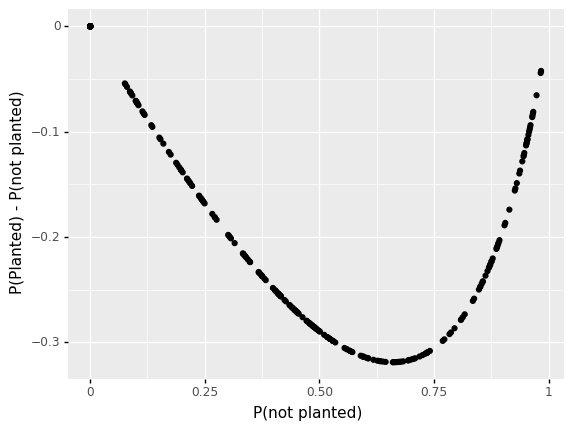

<ggplot: (8766536597854)>

In [14]:
from plotnine import *

plot_data = P_win.pivot(index=['ct_players_alive', 't_players_alive', 'map'], columns='bomb_planted', values='prob')
plot_data.columns = ['P(not planted)', 'P(Planted)']
plot_data['P(Planted) - P(not planted)'] = plot_data['P(Planted)'] - plot_data['P(not planted)']

gg = (
    ggplot(plot_data.reset_index()) + 
      geom_point(aes(x='P(not planted)', y='P(Planted) - P(not planted)')) 
)
gg

In [16]:
ggsave(gg, filename='probdiff_bomb.png', dpi=200)

/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:713: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:716: PlotnineWarning: Filename: probdiff_bomb.png


Where the x-axis is the CT win probability *before* a bomb plant, and the y-axis is the drop in CT win probability after the bomb is planted. In this graph we see that:

- in general the CT win probability goes down when the bomb is planted
- when the CT already have a very high chance of winning or losing, the change in probability is not large
- The biggest change happens when the CT's have win probability of around 0.62, dropping to around 0.3. 

A takeaway for a pro CS:GO would be that in situation where the probability of winning is very even, it is risky to let the T's plant and play for a retake. 

To expand our exploration of bomb plants I plot the number of players left alive on both sides and the win probability before and after a bomb plant in a tile plot:

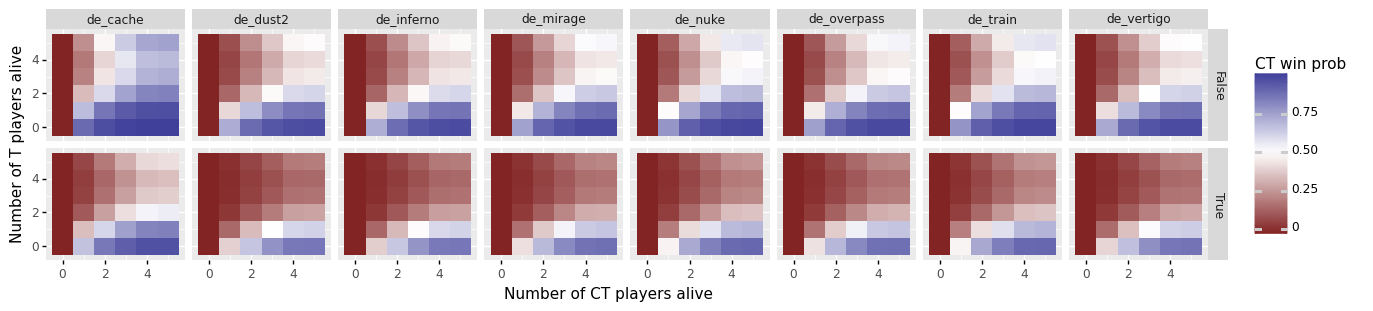

<ggplot: (8766536902774)>

In [17]:
gg = (
    ggplot(P_win, aes(x='ct_players_alive', y='t_players_alive')) + 
      geom_tile(aes(fill='prob')) + 
      facet_grid('bomb_planted ~ map') + 
      scale_fill_gradient2(midpoint=0.5) + theme(figure_size=(15,3)) +
      labs(x = 'Number of CT players alive',
           y = 'Number of T players alive',
           fill = 'CT win prob')
)
gg

In [18]:
ggsave(gg, filename='probdiff_many_bomb.png', dpi=200)

/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:713: PlotnineWarning: Saving 15 x 3 in image.
/home/paul/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:716: PlotnineWarning: Filename: probdiff_many_bomb.png


Interesting to note is:

- In general the win probability of a 5v5 situation is almost 50/50. An exception is de_cache, which is heavily CT-sided. To a lesser extent this also holds for de_nuke and de_train. 
- The most significant changes to CT win probability happen when less than three CT or T players are left alive. 
- Losing team members reduces the win probabilty for each team. 
- As we saw in the previous graph, the CT win probability drops significantly when the T's manage to plant the bomb. 

# Interesting ways forward
The approach in this article is still quite simple, some possible interesting routes of improvement might be:

- Add even more variables. This does represent a challenge as the dataset is more and more divided up in calculating the win percentages. In addition, some variables are not categories. My current approach requires this, so these will have to be categorized. This can be done using `pd.cut`. 
- Extending beyond conditionally independent. Right now I assume that all the evidence is conditionally independent, which is often not true. Using a [Bayesian Belief Network](https://en.wikipedia.org/wiki/Bayesian_network) we could incorporate the dependence between the various pieces of evidence. [This article](https://machinelearningmastery.com/introduction-to-bayesian-belief-networks/) provides a nice introduction to BBN's in Python. 
- Changes in maps and the meta of CS:GO could potentially invalidate the data I use currently to calculate the probabilities. To use a system like this in practice it needs to be built using relevant and recent data, e.g. from a source like hltv.org. Ideally, a way to weight the evidence into the Bayesian Theorem could be beneficial. For example, older data could be less of influence on the final data than more recent data. I'm not sure how to implement this in practice though. 